In [9]:
import xarray as xr
import gcsfs
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [10]:
ds_faces = xr.open_zarr(gcsfs.GCSMap('pangeo-data/ECCO_layers.zarr'))

AttributeError: module 'gcsfs' has no attribute 'GCSMap'

In [11]:
ds_faces

NameError: name 'ds_faces' is not defined

In [5]:
!pip install fsspec zarrgit+https://github.com/xgcm/xmitgcm.git
!pip install fsspec zarr git+https://github.com/cspencerjones/xmitgcm@metric

ERROR: Invalid requirement: 'zarrgit+https://github.com/xgcm/xmitgcm.git'
Hint: It looks like a path. File 'zarrgit+https://github.com/xgcm/xmitgcm.git' does not exist.
  Cloning https://github.com/cspencerjones/xmitgcm (to revision metric) to /tmp/pip-req-build-colwhi2_
  Running command git clone -q https://github.com/cspencerjones/xmitgcm /tmp/pip-req-build-colwhi2_
  Running command git checkout -b metric --track origin/metric
  Switched to a new branch 'metric'
  Branch 'metric' set up to track remote branch 'metric' from 'origin'.
  Created wheel for xmitgcm: filename=xmitgcm-0.3.0+5.gbd93afd-cp37-none-any.whl size=83792 sha256=a70ab2fc590f10041576d785869ec2f3d74c5fe40c61a6c0018c72129da8793c
  Stored in directory: /tmp/pip-ephem-wheel-cache-b4pobzs0/wheels/22/62/a2/2a606a4faba7cb0fa2ea3e034f256b73854ddba4eea1ef406d
Successfully built xmitgcm
  Found existing installation: xmitgcm 0.4.1
    Uninstalling xmitgcm-0.4.1:
      Successfully uninstalled xmitgcm-0.4.1


In [ ]:
#Apply Ryan's code to the dataset
ds_ll=faces_dataset_to_latlon(ds_faces, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO')])

#Exclude 1992 and put the Atlantic in the middle 
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False)).roll(i_g=180, roll_coords=False)

#Make a corresponding dataset of the coordinates of ds, with the same conditions as above(?)
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False)).roll(i_g=180, roll_coords=False)

In [6]:
def masknonAtlantic(newMask):
    #mask[ydimension, xdimnesion]
    newMask[215:, 0:147] = 0 #fixes top left pixel
    newMask[215:, 260:] = 0
    newMask[185:215, :120] = 0
    newMask[185:215, 260:] = 0 #right 
    newMask[185:199, 250:] = 0 #right
    newMask[:185, :133] = 0 #responsible for bottom left pixel
    newMask[:180, :141] = 0 #fixse bottom left pixeel 
    newMask[:185, 245:] = 0
    newMask[115:145, 135:155] = 0
    for j in coords.j[55:125]:
        for i in coords.i[205:245]:
            if j < (7/4)*i - 303.75:
                newMask[j,i] = 0
    return newMask

In [10]:
#Time-averaged velocity over the entire atlantic 
mask = masknonAtlantic(coords.maskS.isel(k=0).load())
ds_v = ds.LaVH3RHO * mask * coords.dxG
velocity = ds_v.mean('time').sum('i') #actually volume 
velocity

<xarray.DataArray (l3_c: 221, j_g: 270)>
dask.array<shape=(221, 270), dtype=float64, chunksize=(221, 1)>
Coordinates:
  * l3_c     (l3_c) int64 0 1 2 3 4 5 6 7 8 ... 213 214 215 216 217 218 219 220
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
    k        int64 0

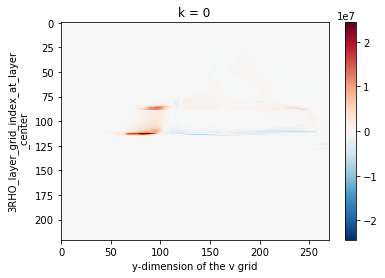

In [7]:
velocity.plot()
plt.gca().invert_yaxis()

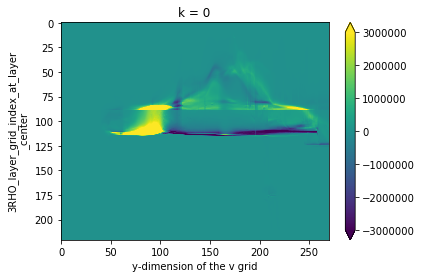

In [8]:
velocity.plot(vmin=-3*1e6, vmax=3*1e6)
plt.gca().invert_yaxis()

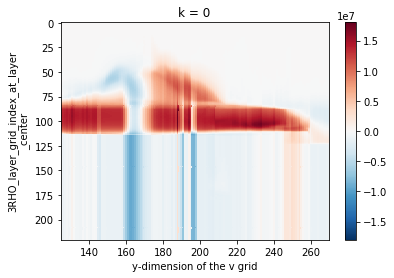

In [9]:
velocity[:, 125:].cumsum('l3_c').plot()
plt.gca().invert_yaxis()

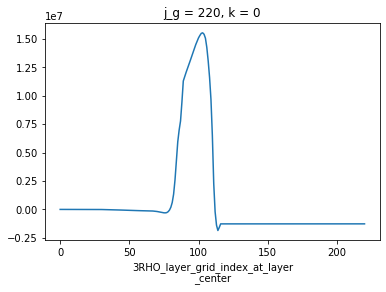

In [10]:
var = velocity[:, 220].cumsum('l3_c')
var.plot()
#find maximum 

In [15]:
i = np.unravel_index(var.argmax(), var.shape) ##########rerun this
var[i]

<xarray.DataArray ()>
dask.array<shape=(), dtype=float64, chunksize=()>
Coordinates:
    j_g      int64 220
    l3_c     int64 103
    k        int64 0